In [1]:
import polars as pl
import plotnine as pn 
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lime.lime_text import LimeTextExplainer
from transformers import pipeline
from IPython.core.display import display, HTML

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
C:\Users\Brandon Kim\AppData\Local\Temp\ipykernel_14468\689722529.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display


In [2]:
# luckily the data isnt that big now so its fine
df = pl.read_csv('top10games_sentiments.parquet')

In [3]:
df.head()

game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,sadness,joy,love,anger,fear,surprise
str,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64
"""Terraria""",76561199105280506,0,3,1432,42,1390,"""only poopy men play this""","""2023-11-01T12:25:45.000""",0,0,0,0.454545,0,1,0.007617,0.049914,0.002272,0.928956,0.009822,0.001419
"""Terraria""",76561198023056574,166,9,27678,2508,27678,"""boulders""","""2023-10-31T23:37:18.000""",0,0,0,0.456432,0,1,0.067185,0.04525,0.005997,0.275528,0.587827,0.018213
"""Terraria""",76561198801133938,52,9,15015,0,15015,"""jungle slimes.""","""2023-10-31T21:48:54.000""",0,2,0,0.545455,0,1,0.022608,0.0157,0.002225,0.329094,0.62629,0.004084
"""Terraria""",76561199174242068,42,2,1937,6,1937,"""I hate terraria because it too…","""2023-10-31T16:33:31.000""",0,0,0,0.0,0,1,0.073236,0.009079,0.001078,0.914031,0.001945,0.00063
"""Terraria""",76561199498962728,1,1,756,756,462,"""If your normie you don't have …","""2023-10-31T12:12:19.000""",0,0,0,0.47619,0,0,0.048683,0.034301,0.001517,0.835626,0.078487,0.001386


In [4]:
df.group_by('game').agg([pl.col('sadness').mean().alias('mean_sadness'),
                         pl.col('joy').mean().alias('mean_joy'),
                         pl.col('love').mean().alias('mean_love'),
                         pl.col('anger').mean().alias('mean_anger'),
                         pl.col('fear').mean().alias('mean_fear'),
                         pl.col('surprise').mean().alias('mean_surprise')
                         ])

game,mean_sadness,mean_joy,mean_love,mean_anger,mean_fear,mean_surprise
str,f64,f64,f64,f64,f64,f64
"""Grand Theft Auto V""",0.197412,0.270414,0.009612,0.468592,0.048077,0.005892
"""PUBG: BATTLEGROUNDS""",0.216807,0.276601,0.007572,0.435619,0.057158,0.006242
"""Among Us""",0.197519,0.243875,0.010132,0.473726,0.065105,0.009643
"""Terraria""",0.212866,0.275887,0.011338,0.427607,0.064379,0.007923
"""Counter-Strike 2""",0.176735,0.23337,0.008731,0.525074,0.050649,0.005443
"""Tom Clancy's Rainbow Six Siege""",0.20411,0.245682,0.010307,0.483593,0.050547,0.005762
"""Garry's Mod""",0.190536,0.273796,0.009854,0.454428,0.063597,0.007789
"""ELDEN RING""",0.278832,0.341393,0.008389,0.294603,0.064848,0.011934
"""Team Fortress 2""",0.20212,0.290695,0.013476,0.433061,0.053279,0.007369


In [5]:
df_pd = df.to_pandas() 
df_pd['game'] = pd.Categorical(df_pd['game'], 
                               categories=['Counter-Strike 2','Terraria',
                                           'Team Fortress 2',
                                            "Tom Clancy's Rainbow Six Siege",
                                            'Grand Theft Auto V',
                                            'Rust',
                                            "Garry's Mod",
                                            'Among Us',
                                            'PUBG: BATTLEGROUNDS',
                                            'ELDEN RING']
                                            [::-1])

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 6605 rows containing non-finite values.


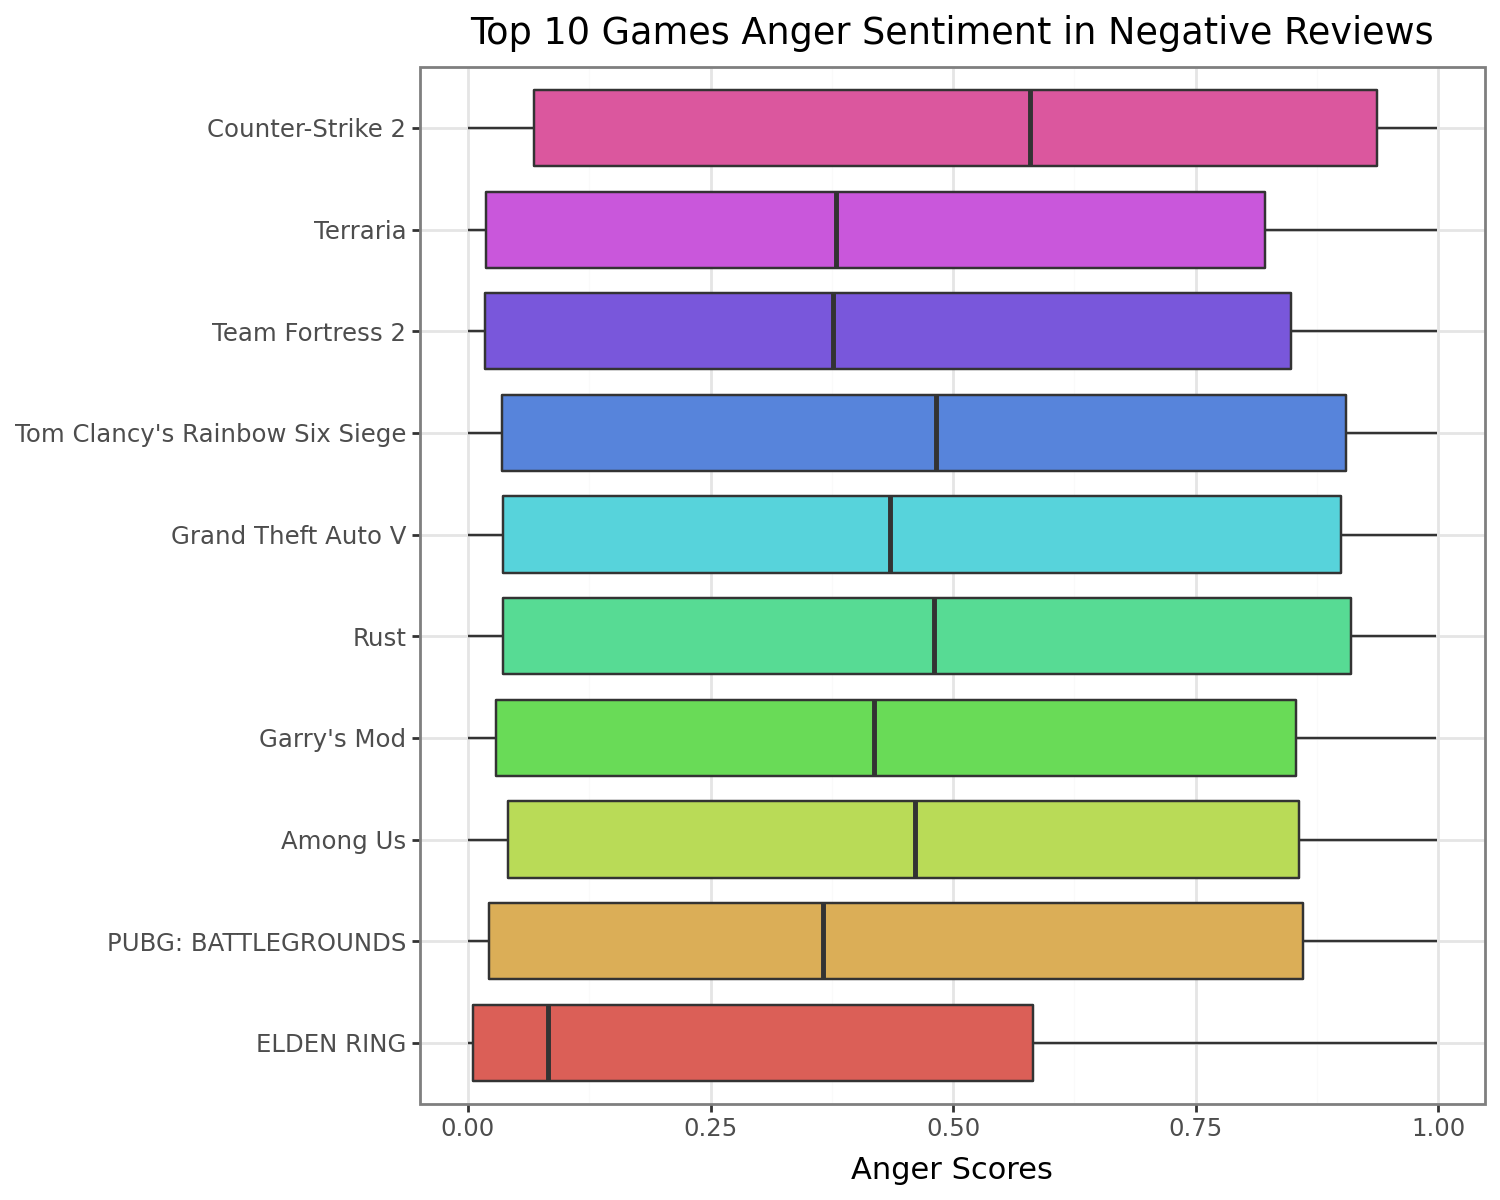

In [16]:
# boxplots of review lengths 
(
    pn.ggplot(df_pd, pn.aes('game', 'anger', fill='game'))
    + pn.geom_boxplot(outlier_shape = None) 
    + pn.coord_flip()
    + pn.labs(x='', y='Anger Scores', title='Top 10 Games Anger Sentiment in Negative Reviews') 
    + pn.theme_bw()
    + pn.guides(fill = False)
    + pn.theme(figure_size=(7.5,6))
)

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 6605 rows containing non-finite values.


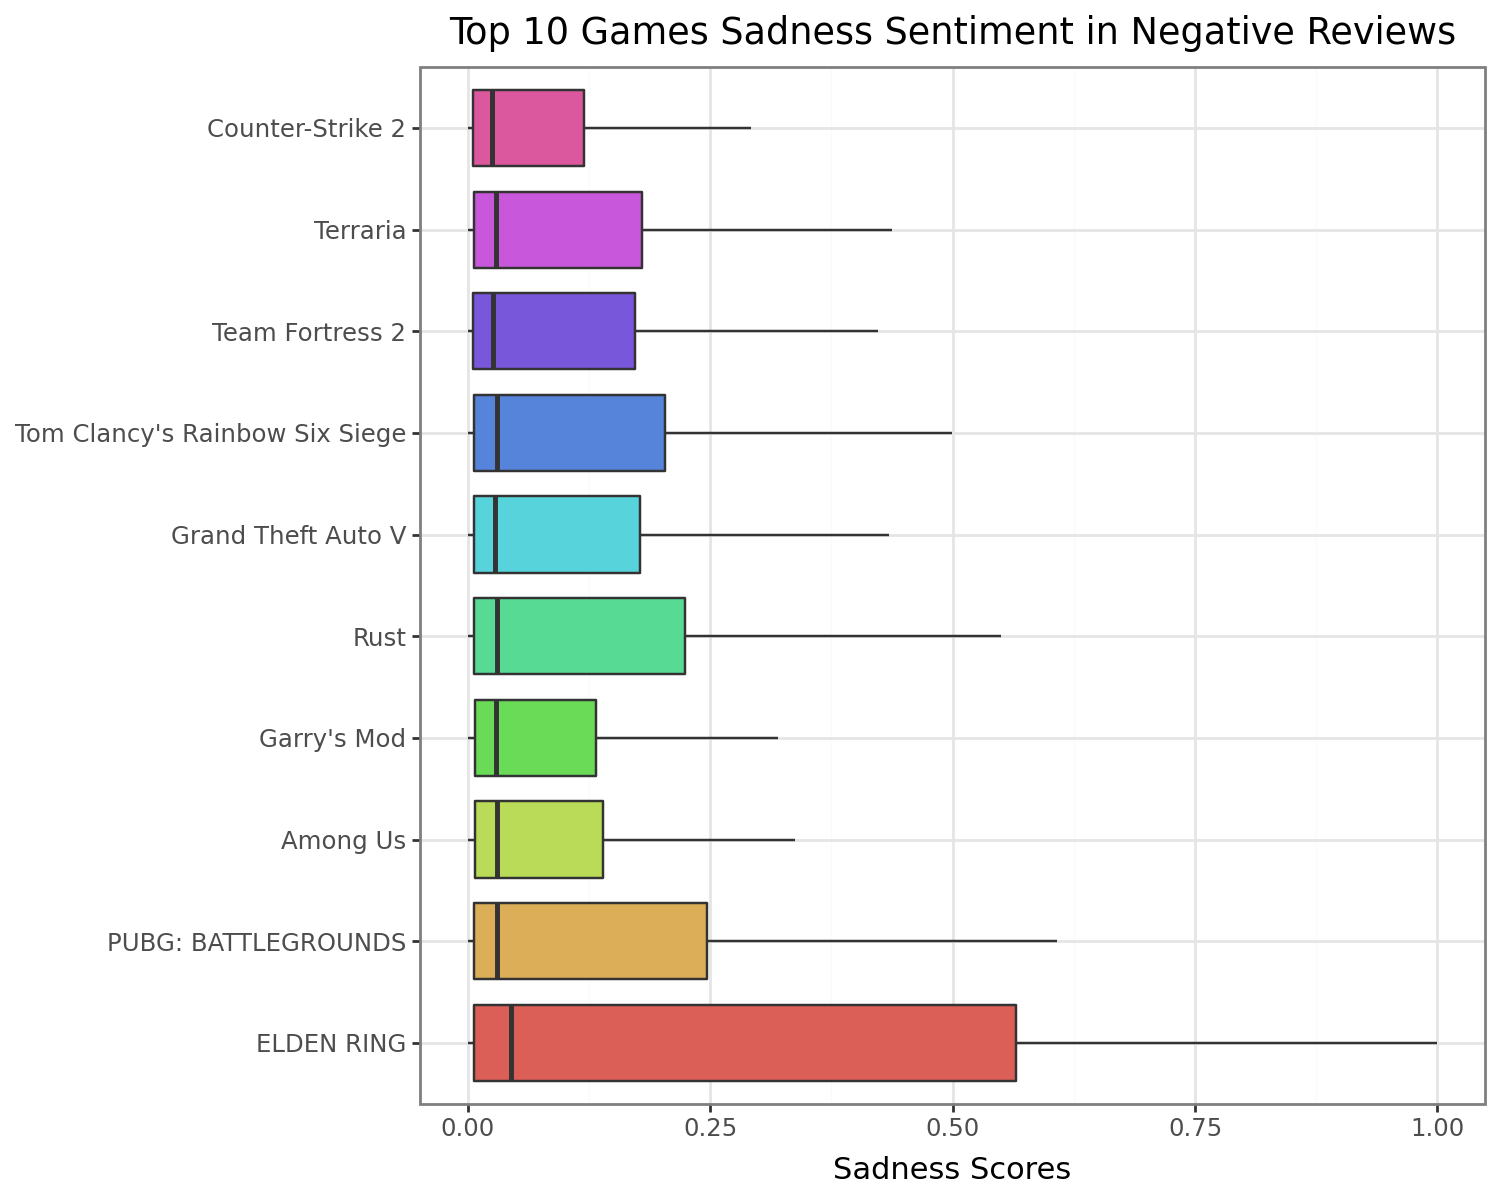

In [17]:
(
    pn.ggplot(df_pd, pn.aes('game', 'sadness', fill='game'))
    + pn.geom_boxplot(outlier_shape = None) 
    + pn.coord_flip()
    + pn.labs(x='', y='Sadness Scores', title='Top 10 Games Sadness Sentiment in Negative Reviews') 
    + pn.theme_bw()
    + pn.guides(fill = False) 
    + pn.theme(figure_size=(7.5,6))
)

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 6605 rows containing non-finite values.


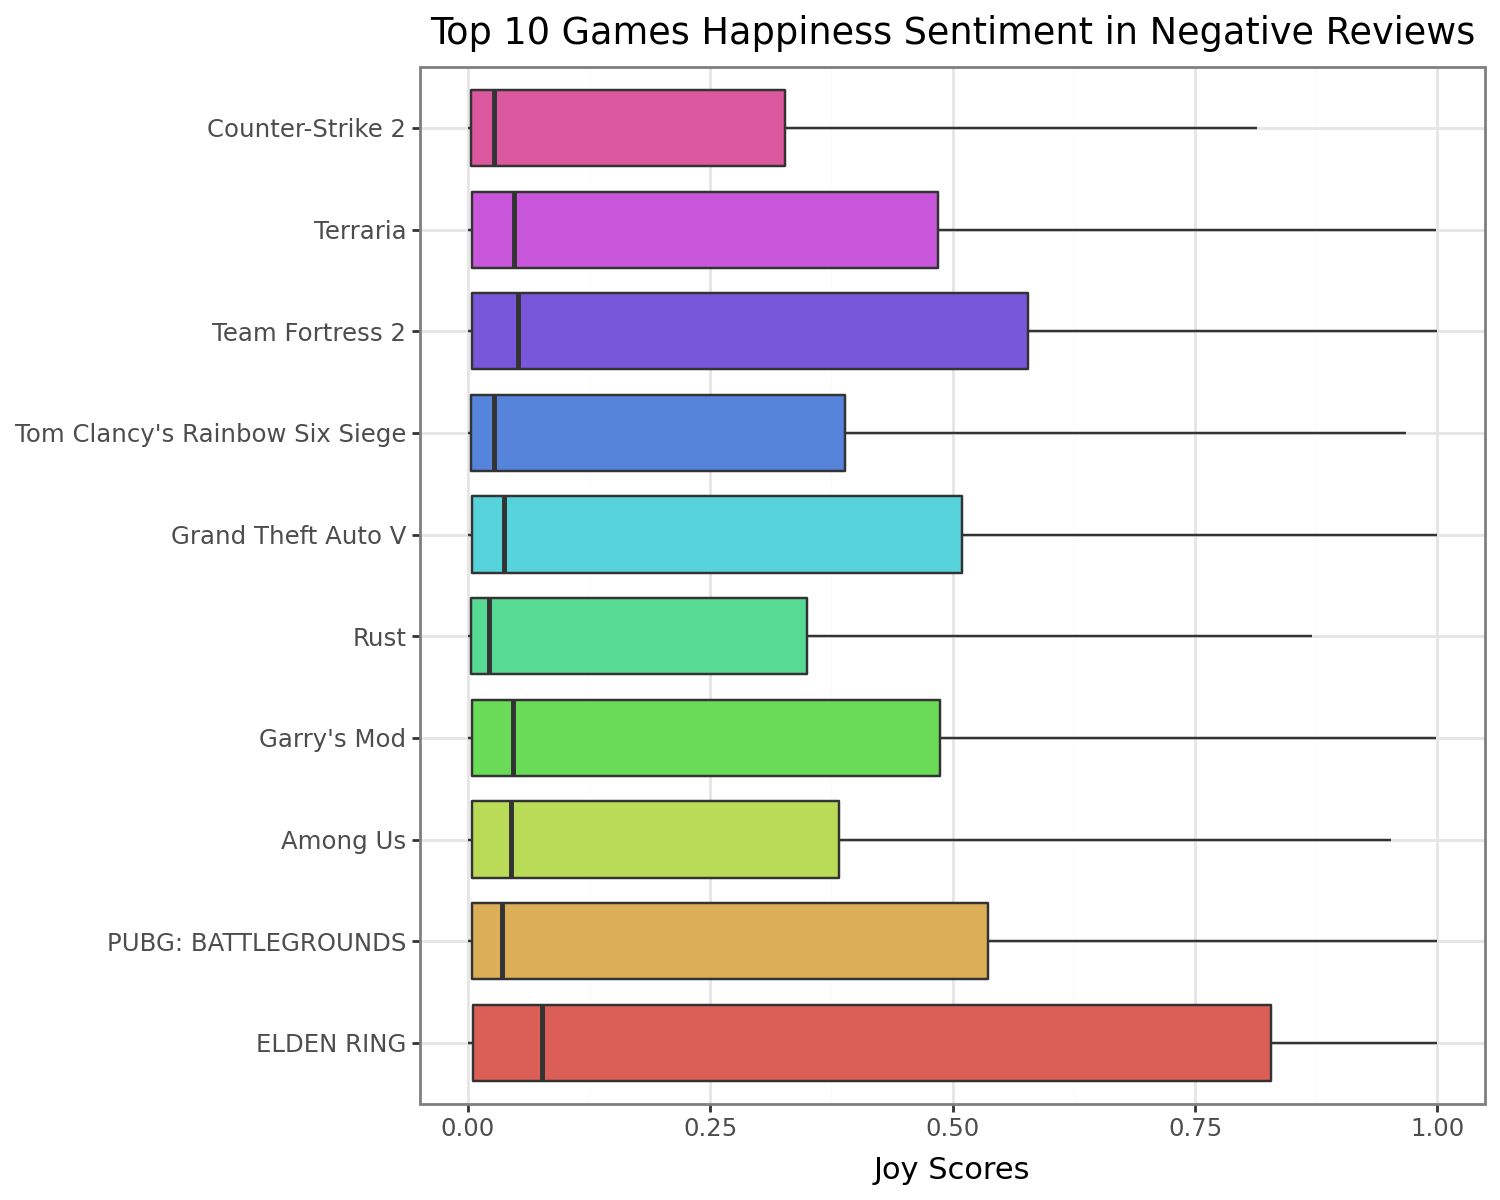

In [10]:
(
    pn.ggplot(df_pd, pn.aes('game', 'joy', fill='game'))
    + pn.geom_boxplot(outlier_shape = None) 
    + pn.coord_flip()
    + pn.labs(x='', y='Joy Scores', title='Top 10 Games Happiness Sentiment in Negative Reviews') 
    + pn.theme_bw()
    + pn.guides(fill = False) 
    + pn.theme(figure_size=(7.5,6))
)

In [13]:
df.drop_nulls().filter(pl.col('game') == 'ELDEN RING').sort('joy', descending=True).head()

game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,sadness,joy,love,anger,fear,surprise
str,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64
"""ELDEN RING""",76561198043684654,782,72,972,0,972,"""I still have no idea why it's …","""2023-01-21T19:36:09.000""",0,0,0,0.0,0,1,0.000179,0.999089,0.000346,0.000107,0.000111,0.000168
"""ELDEN RING""",76561197961499741,0,7,9521,0,306,"""I tried to like this game. Not…","""2022-12-17T21:22:06.000""",0,1,0,0.408244,0,1,0.000164,0.999083,0.000383,0.000103,0.00011,0.000157
"""ELDEN RING""",76561197978253908,0,9,12969,0,10942,"""6/10 targeting is hella garba…","""2022-05-07T01:44:23.000""",0,3,0,0.500421,0,1,0.000189,0.999035,0.000334,0.000138,0.000126,0.000177
"""ELDEN RING""",76561197979724838,0,368,155,0,155,"""Elden Ring is the first FromSo…","""2022-02-25T18:47:55.000""",0,0,0,0.46129,0,0,0.00019,0.999026,0.000336,0.000126,0.000133,0.00019
"""ELDEN RING""",76561198048144132,0,2,22566,323,470,"""I'm running on a 3080 and an I…","""2022-02-25T17:27:40.000""",0,0,0,0.0,0,1,0.000239,0.999025,0.00032,0.000122,0.00012,0.000174


In [6]:
joy_reviews = df.drop_nulls().filter(pl.col('game') == 'ELDEN RING').sort('joy', descending=True)['review'].head(5).to_list()
joy_reviews

["I still have no idea why it's so loved. It's ok But honestly just another souls like. Nothing here stands out to me besides the buildings looking cool I guess.",
 "I tried to like this game. Nothing about overcoming the challenging design feels rewarding. Leveling the character does not feel rewarding or meaningful. Story is not compelling, in fact it feels nonexistant. Don't really understand the hype and praise.",
 '6/10  targeting is hella garbage, a little to big stone between you and a mob can break line of sight and attacks from the sky can miss if you cast from behind a fence. Loot works like in diablo you can find the demon slayer 5000 underneath a rock but if you kill litterally god all you get ist a cool stick and 2 souls. Rearly any boss feels rewarding to kill and the best way to play this game is simply to avoid most of the boss fights and google everything. Enjoy the open world, its atleast something to look at.',
 "Elden Ring is the first FromSoft game that has given m

In [7]:
# sentiment function for LIME 
emotion_classifier = pipeline(
    "text-classification", 
    model="bhadresh-savani/distilbert-base-uncased-emotion", 
    return_all_scores=True
)

Device set to use cuda:0
c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [15]:
# func for lime 
def predict_probs(texts):
    predictions = []
    for text in texts:
        model_output = emotion_classifier(text)[0]  
        scores = [entry['score'] for entry in model_output]  
        predictions.append(scores)
    return np.array(predictions)

In [22]:
# LIME Explainer 
class_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
explainer = LimeTextExplainer(class_names = class_names, 
                              bow = False
                              )

In [10]:
display(HTML("""
    <style>
        .lime {
            background-color: white !important;
        }
        .lime .lime-label {
            background-color: white !important;
            color: black !important;
        }
        .lime .lime-exp {
            background-color: white !important;
            border: 1px solid #ddd;
        }
        .lime .lime-exp div {
            background-color: white !important;
        }
    </style>
"""))

In [17]:
exp = explainer.explain_instance(joy_reviews[0], predict_probs, num_features=10)
exp.show_in_notebook(text=True)

In [18]:
angry_reviews = df.drop_nulls().filter(pl.col('game') == 'ELDEN RING').sort('anger', descending=True)['review'].head(5).to_list()
angry_reviews

["You have already played this game, it was released in 2015 dubbed Dark Souls 3. Except, this version is copy and pasted garbage with different terminology.   Snipped most of this because little wet wipes are getting offended because i don't like the game.... LOL.  4/10. Fu***** sh!te.",
 'I know this game is suppose to be hard. I have never been this angry/frustrated with a game before. I will probably keep playing',
 'No saves, difficulty does not let you relax at all.  You become angry and feel frustration.',
 'Horrible game!!! This game has no guidance and no difficulty settings.  If you like games that just make you extremely angry then this is for you.',
 'Garbage! Hated it and they refused to refund my money. Not even a gift card for something I can play.  Totally disgusted.']

In [26]:
exp = explainer.explain_instance(angry_reviews[1], predict_probs, num_features=10, labels = [class_names.index("anger")])
exp.show_in_notebook(text=True)

In [6]:
# removing love for the sake of multicollinearity
df_glm = df_pd[df_pd['game'] == 'ELDEN RING'][['sadness', 'joy', 'fear', 'surprise', 'anger', 'author_playtime_at_review']].dropna()

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 1131'. Pick better value with 'binwidth'.


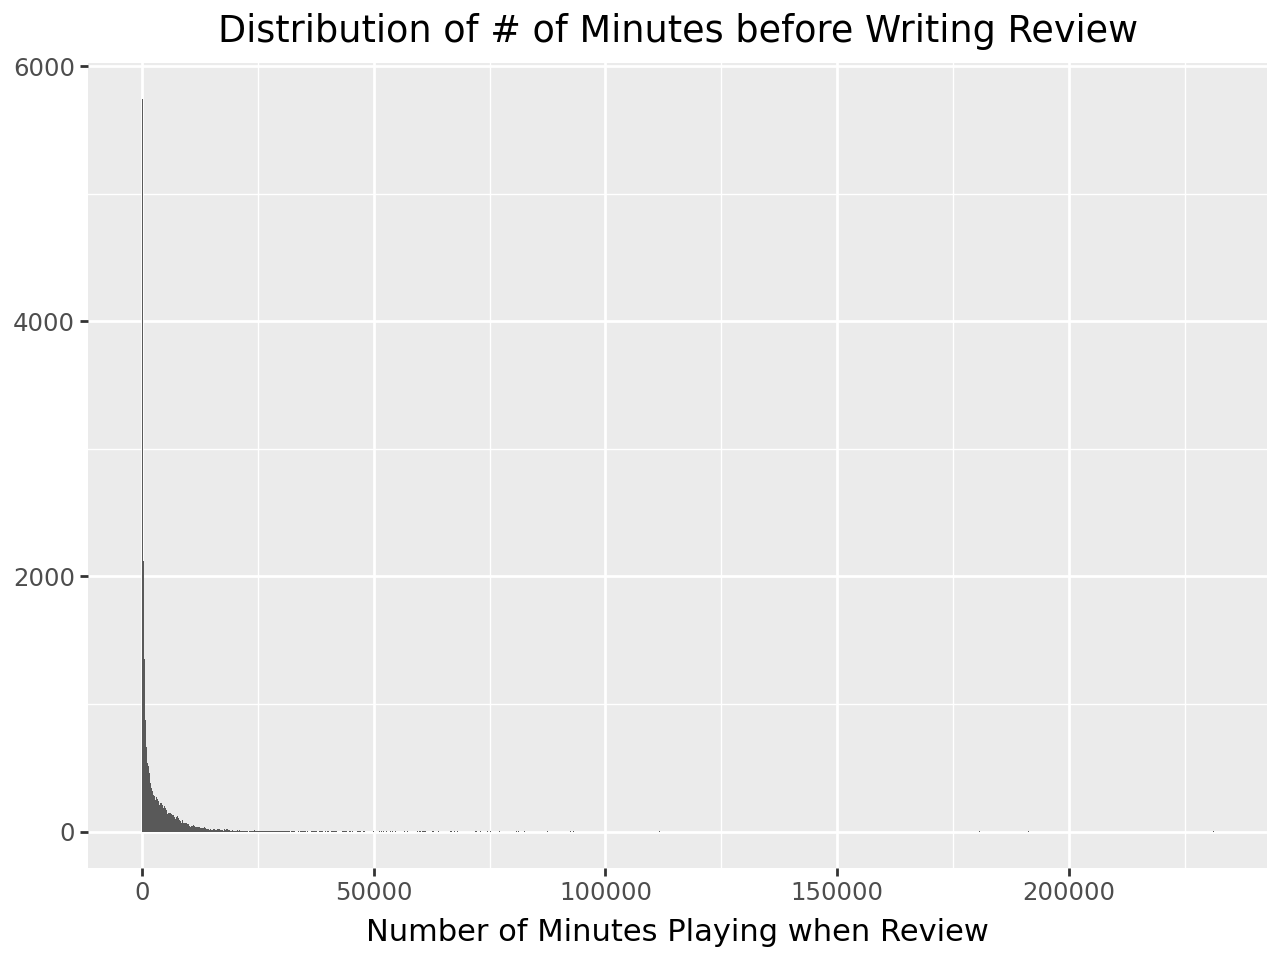

In [7]:
(
    pn.ggplot(df_glm, pn.aes('author_playtime_at_review'))
    + pn.geom_histogram() 
    + pn.labs(x = 'Number of Minutes Playing when Review', y ='', title = 'Distribution of # of Minutes before Writing Review')

)

In [8]:
np.mean(df_glm['author_playtime_at_review'])

2683.036877837143

In [9]:
np.var(df_glm['author_playtime_at_review'])

34355646.754274145

In [154]:
df_glm.columns

Index(['sadness', 'joy', 'fear', 'surprise', 'anger',
       'author_playtime_at_review'],
      dtype='object')

In [155]:
formula = "author_playtime_at_review ~ " + " + ".join(df_glm.columns[0:5].tolist())
formula 

'author_playtime_at_review ~ sadness + joy + fear + surprise + anger'

In [156]:
np.random.seed(369)
model = smf.glm(formula=formula, data=df_glm, family=sm.families.NegativeBinomial()).fit()

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


In [157]:
print(model.summary())

                     Generalized Linear Model Regression Results                     
Dep. Variable:     author_playtime_at_review   No. Observations:                24893
Model:                                   GLM   Df Residuals:                    24887
Model Family:               NegativeBinomial   Df Model:                            5
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -2.2125e+05
Date:                       Thu, 06 Mar 2025   Deviance:                       77149.
Time:                               17:47:26   Pearson chi2:                 1.17e+05
No. Iterations:                            8   Pseudo R-squ. (CS):            0.01333
Covariance Type:                   nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------